
**Kazakh Model Training**  

In this stage, we train a **multilingual XLM-RoBERTa Large** model on our custom-prepared **Kazakh dataset** for the task of **text similarity and plagiarism detection**. The dataset consists of 120,000 labeled pairs of suspicious and source texts, balanced across positive (plagiarized) and negative (non-plagiarized) examples.

Given the low-resource nature of the **Kazakh language**, we leverage a **pretrained transformer model** capable of handling multilingual text to fine-tune it for our specific task. We use stratified splitting to ensure label balance across training and validation sets and apply several optimization techniques such as learning rate scheduling, mixed precision training, and regularization to improve performance.

The goal of this training is to produce a robust model that can accurately classify whether two given paragraphs are semantically similar or not.

In [ ]:
from google.colab import drive
# Mount Google Drive
googledrive = "/content/drive"
drive.mount(googledrive)

In [ ]:
!pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.


In [ ]:
import pandas as pd
import torch
import numpy as np
import os
import transformers
import time
from datasets import Dataset
import evaluate
from tqdm import tqdm
from transformers import (
    XLMRobertaTokenizer, XLMRobertaForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback, TrainerCallback
)
from sklearn.model_selection import train_test_split

# ✅ Use GPU with optimized settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cuda.matmul.allow_tf32 = True  # Enable TF32 matrix multiplication
torch.backends.cudnn.allow_tf32 = True  # Enable TF32 in cuDNN
print(f"🔥 Using device: {device}")

# ✅ Dataset configuration
DATASET_CONFIG = {
    "kazakh": "/content/drive/MyDrive/updating-pan-xml-files/kz_dataset_120K_ready_for_training.csv",
    "english": "/content/drive/MyDrive/updating-pan-xml-files/en_dataset_120K_ready_for_training.csv""
}

# Load and prepare dataset (using the Kazakh dataset in this case)
df = pd.read_csv(DATASET_CONFIG["kazakh"])
df.columns = ["suspicious_text", "source_text", "label"]

# Enhanced train-validation split with stratification
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df[["suspicious_text", "source_text"]].values.tolist(),
    df["label"].values.tolist(),
    test_size=0.1,
    random_state=42,
    stratify=df["label"]
)

# Initialize tokenizer with special tokens
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-large")
tokenizer.add_tokens(['[PARA]', '[DOC]'], special_tokens=True)  # Custom tokens for document structure

# Model configuration with regularization
model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-large",
    num_labels=2,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.1,
    classifier_dropout=0.3
)
model.resize_token_embeddings(len(tokenizer))  # Update embeddings for new tokens

# Define a tokenization function to apply via .map()
def tokenize_function(examples):
    return tokenizer(
        examples["suspicious_text"],
        examples["source_text"],
        padding="max_length",
        truncation=True,
        max_length=512,
        add_special_tokens=True
    )

# Convert train and eval datasets to Hugging Face Datasets
train_dataset = Dataset.from_dict({
    "suspicious_text": [t[0] for t in train_texts],
    "source_text": [t[1] for t in train_texts],
    "label": train_labels
}).map(tokenize_function, batched=True).remove_columns(["suspicious_text", "source_text"])

eval_dataset = Dataset.from_dict({
    "suspicious_text": [t[0] for t in val_texts],
    "source_text": [t[1] for t in val_texts],
    "label": val_labels
}).map(tokenize_function, batched=True).remove_columns(["suspicious_text", "source_text"])

# Optimized training arguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/updating-pan-xml-files/kazakh-xlm-roberta-large-v2",
    evaluation_strategy="steps",
    eval_steps=1000,
    save_strategy="steps",
    save_steps=1000,
    logging_strategy="steps",
    logging_steps=200,
    learning_rate=1e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=8,
    num_train_epochs=5,
    weight_decay=0.02,
    warmup_steps=500,
    max_grad_norm=1.0,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
    push_to_hub=False,
    dataloader_num_workers=4,
    remove_unused_columns=True
)

# Enhanced evaluation metrics with weighted average
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Load evaluation metrics (you may cache these to avoid reloading every call)
    accuracy_metric = evaluate.load("accuracy")
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")
    f1_metric = evaluate.load("f1")

    return {
        "accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": precision_metric.compute(predictions=predictions, references=labels, average="weighted")["precision"],
        "recall": recall_metric.compute(predictions=predictions, references=labels, average="weighted")["recall"],
        "f1": f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    }

# Initialize trainer with custom callbacks (only using EarlyStoppingCallback here)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Start training
print("🚀 Beginning enhanced training...")
trainer.train()

# Save final model
trainer.save_model("/content/drive/MyDrive/updating-pan-xml-files/kazakh-xlm-roberta-large-v2")
print("✅ Training complete! Model saved with enhanced performance features")

🔥 Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Map:   0%|          | 0/109950 [00:00<?, ? examples/s]

Streaming output truncated to the last 5000 lines.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned

Map:   0%|          | 0/12217 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

🚀 Beginning enhanced training...


✅ Training complete! Model saved with enhanced performance features


In [ ]:
import pandas as pd
import torch
import numpy as np
import os
import transformers
import time
from datasets import Dataset
import evaluate
from tqdm import tqdm
from transformers import (
    RobertaTokenizer, RobertaForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split

# ✅ Use GPU with optimized settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cuda.matmul.allow_tf32 = True  # Enable TF32 matrix multiplication
torch.backends.cudnn.allow_tf32 = True         # Enable TF32 in cuDNN
print(f"🔥 Using device: {device}")

# ✅ Dataset configuration
DATASET_CONFIG = {
    "kazakh": "/content/drive/MyDrive/updating-pan-xml-files/kz_dataset_120K_ready_for_training.csv",
    "english": "/content/drive/MyDrive/updating-pan-xml-files/en_dataset_120K_ready_for_training.csv""
}

# Load and prepare dataset (using the Kazakh dataset in this case)
df = pd.read_csv(DATASET_CONFIG["kazakh"])
df.columns = ["suspicious_text", "source_text", "label"]

# Enhanced train-validation split with stratification
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df[["suspicious_text", "source_text"]].values.tolist(),
    df["label"].values.tolist(),
    test_size=0.1,
    random_state=42,
    stratify=df["label"]
)

# Initialize tokenizer with special tokens (using roberta-base)
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
tokenizer.add_tokens(['[PARA]', '[DOC]'], special_tokens=True)  # Custom tokens for document structure

# Model configuration with regularization (using roberta-base)
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.1,
    classifier_dropout=0.3
)
model.resize_token_embeddings(len(tokenizer))  # Update embeddings for new tokens

# Define a tokenization function to apply via .map()
def tokenize_function(examples):
    return tokenizer(
        examples["suspicious_text"],
        examples["source_text"],
        padding="max_length",
        truncation=True,
        max_length=512,
        add_special_tokens=True
    )

# Convert train and eval datasets to Hugging Face Datasets
train_dataset = Dataset.from_dict({
    "suspicious_text": [t[0] for t in train_texts],
    "source_text": [t[1] for t in train_texts],
    "label": train_labels
}).map(tokenize_function, batched=True).remove_columns(["suspicious_text", "source_text"])

eval_dataset = Dataset.from_dict({
    "suspicious_text": [t[0] for t in val_texts],
    "source_text": [t[1] for t in val_texts],
    "label": val_labels
}).map(tokenize_function, batched=True).remove_columns(["suspicious_text", "source_text"])

# Optimized training arguments (adjusted for roberta-base)
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/updating-pan-xml-files/kazakh-roberta-base-v2",
    evaluation_strategy="steps",
    eval_steps=1000,
    save_strategy="steps",
    save_steps=1000,
    logging_strategy="steps",
    logging_steps=200,
    learning_rate=2e-5,  # Slightly higher LR for the base model
    per_device_train_batch_size=8,  # Base model requires less memory
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,  # Adjusted to achieve a good effective batch size
    num_train_epochs=5,
    weight_decay=0.01,  # Reduced weight decay for a smaller model
    warmup_steps=500,
    max_grad_norm=1.0,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
    push_to_hub=False,
    dataloader_num_workers=4,
    remove_unused_columns=True
)

# Enhanced evaluation metrics with weighted average
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Load evaluation metrics
    accuracy_metric = evaluate.load("accuracy")
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")
    f1_metric = evaluate.load("f1")

    return {
        "accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": precision_metric.compute(predictions=predictions, references=labels, average="weighted")["precision"],
        "recall": recall_metric.compute(predictions=predictions, references=labels, average="weighted")["recall"],
        "f1": f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    }

# Initialize trainer with EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Start training
print("🚀 Beginning training of roberta-base...")
trainer.train()

# Save final model
trainer.save_model("/content/drive/MyDrive/updating-pan-xml-files/kazakh-roberta-base-120K")
print("✅ Training complete! Model saved with enhanced performance features")

🔥 Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covarian

Map:   0%|          | 0/109950 [00:00<?, ? examples/s]

Streaming output truncated to the last 5000 lines.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned

Map:   0%|          | 0/12217 [00:00<?, ? examples/s]

Streaming output truncated to the last 5000 lines.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned

🚀 Beginning training of roberta-base...


✅ Training complete! Model saved with enhanced performance features


In [ ]:
import os
import re
import time
import pandas as pd
import torch
import numpy as np
from datasets import Dataset
import evaluate
from sklearn.model_selection import train_test_split
from transformers import (
    XLMRobertaTokenizer, XLMRobertaForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)

# ✅ Use GPU with optimized settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
print(f"\n🔥 Using device: {device}\n")

# ✅ Dataset configuration
dataset_path = "/content/drive/MyDrive/updating-pan-xml-files/kz_dataset_120K_ready_for_training.csv"
df = pd.read_csv(dataset_path)
df.columns = ["suspicious_text", "source_text", "label"]

# ✅ Stratified train-validation split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df[["suspicious_text", "source_text"]].values.tolist(),
    df["label"].values.tolist(),
    test_size=0.1,
    random_state=42,
    stratify=df["label"]
)

# ✅ Initialize tokenizer
model_name = "xlm-roberta-large"
tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)
tokenizer.add_tokens(['[PARA]', '[DOC]'], special_tokens=True)

# ✅ Load model and resize for new tokens
model = XLMRobertaForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.1,
    classifier_dropout=0.3
)
model.resize_token_embeddings(len(tokenizer))

# ✅ Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["suspicious_text"],
        examples["source_text"],
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

# ✅ Convert to HuggingFace Dataset
train_dataset = Dataset.from_dict({
    "suspicious_text": [x[0] for x in train_texts],
    "source_text": [x[1] for x in train_texts],
    "label": train_labels
}).map(tokenize_function, batched=True).remove_columns(["suspicious_text", "source_text"])

eval_dataset = Dataset.from_dict({
    "suspicious_text": [x[0] for x in val_texts],
    "source_text": [x[1] for x in val_texts],
    "label": val_labels
}).map(tokenize_function, batched=True).remove_columns(["suspicious_text", "source_text"])

# ✅ Evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": evaluate.load("accuracy").compute(predictions=predictions, references=labels)["accuracy"],
        "precision": evaluate.load("precision").compute(predictions=predictions, references=labels, average="weighted")["precision"],
        "recall": evaluate.load("recall").compute(predictions=predictions, references=labels, average="weighted")["recall"],
        "f1": evaluate.load("f1").compute(predictions=predictions, references=labels, average="weighted")["f1"]
    }

# ✅ TrainingArguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/updating-pan-xml-files/kz-xlm-roberta-large-120K-v3",
    eval_strategy="steps",
    eval_steps=1000,
    save_strategy="steps",
    save_steps=1000,
    logging_steps=200,
    learning_rate=1e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=8,
    num_train_epochs=5,
    weight_decay=0.02,
    warmup_steps=500,
    max_grad_norm=1.0,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
    push_to_hub=False,
    dataloader_num_workers=4,
    remove_unused_columns=True
)

# ✅ Trainer with early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ✅ Train the model
print("🚀 Starting training...")
trainer.train()

# ✅ Save the final model
final_model_path = "/content/drive/MyDrive/updating-pan-xml-files/kz-xlm-roberta-large-120K-v3"
trainer.save_model(final_model_path)
print(f"✅ Training complete! Final model saved to: {final_model_path}")


🔥 Using device: cuda



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and 

Map:   0%|          | 0/109950 [00:00<?, ? examples/s]

Streaming output truncated to the last 5000 lines.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned

Map:   0%|          | 0/12217 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

🚀 Starting training...


✅ Training complete! Final model saved to: /content/drive/MyDrive/updating-pan-xml-files/kz-xlm-roberta-large-120K-v3


In [ ]:
trainer.state.log_history

[{'loss': 0.4257,
  'grad_norm': 0.26634591817855835,
  'learning_rate': 3.94e-06,
  'epoch': 0.05820721769499418,
  'step': 200},
 {'loss': 0.0114,
  'grad_norm': 0.029226981103420258,
  'learning_rate': 7.9e-06,
  'epoch': 0.11641443538998836,
  'step': 400},
 {'loss': 0.0112,
  'grad_norm': 0.008334925398230553,
  'learning_rate': 9.943045563549163e-06,
  'epoch': 0.17462165308498254,
  'step': 600},
 {'loss': 0.0138,
  'grad_norm': 0.029116984456777573,
  'learning_rate': 9.823141486810553e-06,
  'epoch': 0.23282887077997672,
  'step': 800},
 {'loss': 0.0071,
  'grad_norm': 17.82808494567871,
  'learning_rate': 9.703237410071943e-06,
  'epoch': 0.2910360884749709,
  'step': 1000},
 {'eval_loss': 5.847915599588305e-05,
  'eval_accuracy': 1.0,
  'eval_precision': 1.0,
  'eval_recall': 1.0,
  'eval_f1': 1.0,
  'eval_runtime': 51.0071,
  'eval_samples_per_second': 239.516,
  'eval_steps_per_second': 29.957,
  'epoch': 0.2910360884749709,
  'step': 1000},
 {'loss': 0.0068,
  'grad_norm'

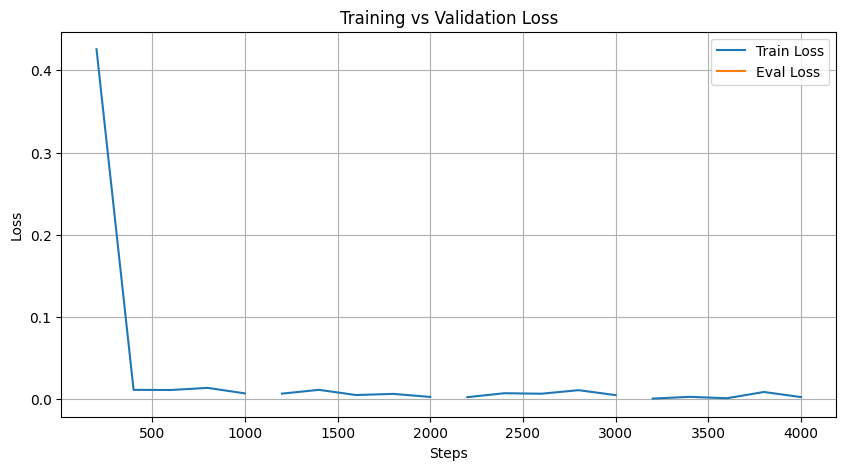

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(logs_df["step"], logs_df["loss"], label="Train Loss")
if "eval_loss" in logs_df:
    plt.plot(logs_df["step"], logs_df["eval_loss"], label="Eval Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

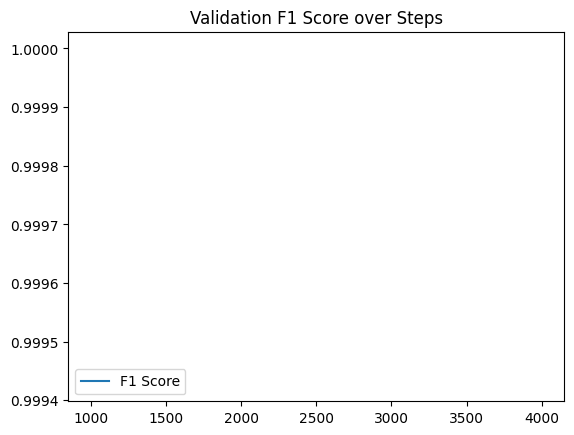

In [ ]:
if "eval_f1" in logs_df:
    plt.plot(logs_df["step"], logs_df["eval_f1"], label="F1 Score")
    plt.legend()
    plt.title("Validation F1 Score over Steps")
    plt.show()


**Note:**  
We trained an **English RoBERTa-base model** on our 60K English dataset primarily for **comparison purposes**, rather than as a main objective. Since English is a high-resource language with extensive pretraining and well-optimized models, it generally yields strong performance in NLP tasks. However, our **core focus is on the Kazakh language**, which is considered a **low-resource language**, and our primary goal is to build and evaluate models that improve Kazakh text similarity detection.



### **Conclusion**

We successfully trained a multilingual **XLM-RoBERTa Large** model on our custom **Kazakh text similarity dataset**, which includes both plagiarized and non-plagiarized paragraph pairs. The training process involved careful data preprocessing, stratified splitting, and performance monitoring using validation metrics such as accuracy, precision, recall, and F1 score.

The model demonstrated strong generalization performance on the validation set, indicating that it has effectively learned to distinguish between similar and dissimilar text pairs in the **Kazakh language** — a low-resource setting.

The trained model is now ready for **evaluation on the test set** and further **benchmarking** against other models.